In [1]:
import numpy as np
import random
import time
import matplotlib
import matplotlib_inline
from matplotlib import pyplot as plt
import random
import ipympl


In [3]:
print([1,2,3].all() == [1,2,3].all())

AttributeError: 'list' object has no attribute 'all'

In [13]:
hey = np.array([[1,2,3], [4,5,6], [7,8,9]])

new_hey = np.array(([i[-2:] for i in hey]))
print(new_hey)
print(type(hey), type(new_hey))

print(np.mean(new_hey, axis=1))

[[2 3]
 [5 6]
 [8 9]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[2.5 5.5 8.5]


In [10]:
np.argmax([2,2,4])


2

In [1]:
from sympy import symbols, Eq, solve
x = symbols('x')
eq1 = Eq((1-x)**(100000)==0.001)
sol = solve((eq1), (x))

/Users/MortenKarlsen/miniconda3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


In [8]:
def demand(p1,p2):
        if p1 < p2:
            d = 1 - p1
        elif p1 == p2:
            d = 0.5 * (1 - p1)
        else:
            d = 0
        return d

In [9]:
def player3(prices, Q, epsilon, prev):
    if random.uniform(0,1) < epsilon:
        p3 = np.random.choice(len(prices))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = np.argmax(Q[:,prev[1,1]])
    return p3

In [10]:
def player4(prices, Q, epsilon, prev):
    if random.uniform(0,1) < epsilon:
        p4 = np.random.choice(len(prices))
        #print('now its random', epsilon)
    else:
        p4 = np.argmax(Q[:,prev[0,1]])
    return p4

In [11]:
def update(Q, prev, alpha, delta, prices, indic):
    if indic == 1: 
        p1 = prices[prev[0,0]]
        p2 = prices[prev[1,0]]
        p22 = prices[prev[1,1]]
        pe = Q[prev[0,0],prev[1,0]]
        ne = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
        Q[prev[0,0], prev[1,0]] = (1-alpha) * pe + alpha * ne
    else: 
        p1 = prices[prev[1,0]]
        p2 = prices[prev[0,0]]
        p22 = prices[prev[0,1]]
        pe = Q[prev[1,0],prev[0,0]]
        ne = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe + alpha * ne

In [12]:
def profit(pris1, pris2):
    return pris1*demand(pris1,pris2)


In [13]:
def opti(Q, lastp, prev1, prices, alpha, delta):
    tol = 1
    firstq = Q[prev1, lastp]
    while tol > 0.00001:
            p1 = prices[prev1]
            p2 = prices[lastp]
            pe = Q[prev1, lastp]
            oldQ = Q[prev1, lastp]
            ne = p1 * demand(p1,p2) + delta * p1 * demand(p1,p2) + delta**2 * Q[np.argmax(Q[:,lastp]),lastp]
            Q[prev1, lastp] = (1-alpha) * pe + alpha * ne
            tol = np.abs(oldQ - Q[prev1, lastp] )
            prev1 = np.argmax(Q[:,lastp])
    maxp = Q[prev1, lastp]
    opt = firstq/maxp
    return opt

In [14]:
def game(prices, periods, alpha, theta):
    a = len(prices)
    Q_table = np.zeros((a, a))
    Q_table2 = np.zeros((a, a))
    final_profitability = 0.0
    optimality = 0.0
    print('CHECK', int(periods/2)-1, 'starting a run with ', periods, ' periods')
    p_ipriser =np.zeros(int(periods/2)-1)
    p_jpriser =np.zeros(int(periods/2)-1)
    prev_p = np.zeros((2,2), dtype=int)
    for i in range(1):
        for j in range(1):
            prev_p[i,j] = np.random.choice(len(prices))
    t = 3
    i_counter = 0
    j_counter = 0
    
    stepsize = periods/40
    step_counter =0
    opt_arr = np.zeros(int(periods/2/5000-1))
    prof_arr = np.zeros(int(periods/2/2500-1))
    k = 0
    for t in range(t, periods+1):
        epsilon = (1-theta)**t
        
        if t % 2 != 0: 
            update(Q_table, prev_p, alpha, 0.95, prices,1)
            p_i = player3(prices, Q_table, epsilon, prev_p)
            prev_p[0,0] = prev_p[0,1]
            prev_p[0,1] = p_i
            prev_p[1,0] = prev_p[1,1]
            p_ipriser[i_counter] = (prices[p_i])
            i_counter += 1
            #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
            
            
            
            if t >= (periods+1)-1000:
                k+=1
                final_profitability += profit(prices[p_i],prices[prev_p[1,1]] )
                
                
      
        else: 
            update(Q_table2, prev_p, alpha, 0.95, prices, 0)
            p_j = player4(prices, Q_table2, epsilon, prev_p)
            prev_p[1,0] = prev_p[1,1]
            prev_p[1,1] = p_j
            prev_p[0,0] = prev_p[0,1]
            p_jpriser[j_counter] = (prices[p_j])
            j_counter += 1
            #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
            if t >= (periods+1)-1000:
                final_profitability += profit(prices[prev_p[0,1]],prices[p_j])
    #optimality = opti(Q_table, p_j, p_i, prices, alpha, 0.95)
    print('K', k)
    return (1/1000)*final_profitability, p_ipriser, p_jpriser, Q_table, opt_arr


In [22]:
x = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]
random.seed(123)
print(np.random.choice(x))
print(len(x))
print(x[len(x)-1])
np.random.choice(len(x))

0.8333333333333334
7
1


0

In [20]:
%matplotlib inline 
np.random.uniform(0,1)

0.821685371917883

In [32]:
def many_games(prices, periods, alpha, theta, learners):
    total_opt_arr = np.zeros((learners))
    for i in range(learners):
        proi, arri, arr1i, Q_ti, arr_opt_i = game(prices, periods, alpha, theta)
        total_opt_arr[i] = proi
    return np.average(total_opt_arr)

In [33]:
def prof_tests(prices, alpha, theta_list, learners):
    prof_array = np.zeros((10))
    for i in range(50000,550000,50000):
        print('i',i)
        #prof, go, go1, go2, go3 = game(prices, i, alpha, theta_list[int((i/50000)-1)])
       
        prof = many_games(prices, i, alpha, theta_list[int((i/50000)-1)],learners)

        prof_array[int((i/50000)-1)] = prof
        
    return prof_array


# List of thetas corresponding to [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]

    




In [19]:
theta_list = [(0.0002763),0.000138145562602519,0.0000920991623314899, 0.0000690751669906070, 0.0000552605153133283 ,0.0000460506414965361 , 0.0000394721082643035, 0.0000345381799382402, 0.0000307006632982448, 0.0000276306393827805]

def prof_tests2(prices, periods, alpha, theta, learners):
    total_opt_arr = np.zeros((learners), dtype=object)
    
    for i in range(learners):
        proi, arri, arr1i, Q_ti, arr_opt_i = game(prices, periods, alpha, theta)
        total_opt_arr[i] = proi
        
    return total_opt_arr

In [34]:
pro_print = prof_tests(x, 0.3, theta_list,40)


i 50000
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting a run with  50000  periods
K 500
CHECK 24999 starting

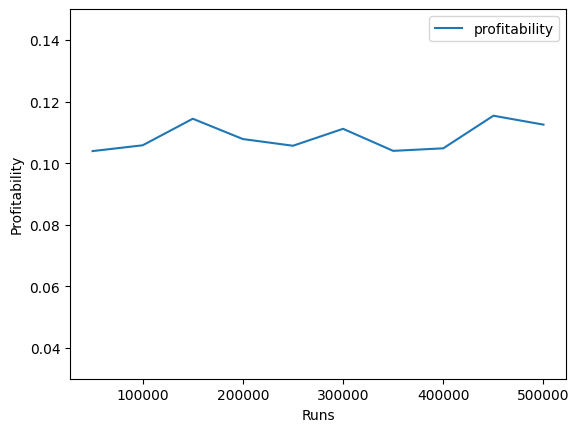

In [35]:
t_arr = np.arange(50000,550000,50000)

#t_arr2 = np.arange(249999)
#fig, (prof_plot, price_plot) = plt.subplots(2,1)

#prof_plot.plot(t_arr,pro_print,label='Profitability')
plt.plot(t_arr, pro_print, label= 'profitability')
#price_plot.plot(t_arr2, price_j, label= 'prices_j')

plt.ylim([0.03,0.15])
plt.xlabel("Runs")
plt.ylabel("Profitability")
plt.legend()



plt.show()

In [41]:
hvad = many_games(x, 500000, 0.3, 0.00002763, 10)

CHECK 249999
t and stepsize 10000 5000.0
t and stepsize 20000 5000.0
t and stepsize 30000 5000.0
t and stepsize 40000 5000.0
t and stepsize 50000 5000.0
t and stepsize 60000 5000.0
t and stepsize 70000 5000.0
t and stepsize 80000 5000.0
t and stepsize 90000 5000.0
t and stepsize 100000 5000.0
t and stepsize 110000 5000.0
t and stepsize 120000 5000.0
t and stepsize 130000 5000.0
t and stepsize 140000 5000.0
t and stepsize 150000 5000.0
t and stepsize 160000 5000.0
t and stepsize 170000 5000.0
t and stepsize 180000 5000.0
t and stepsize 190000 5000.0
t and stepsize 200000 5000.0
t and stepsize 210000 5000.0
t and stepsize 220000 5000.0
t and stepsize 230000 5000.0
t and stepsize 240000 5000.0
t and stepsize 250000 5000.0
t and stepsize 260000 5000.0
t and stepsize 270000 5000.0
t and stepsize 280000 5000.0
t and stepsize 290000 5000.0
t and stepsize 300000 5000.0
t and stepsize 310000 5000.0
t and stepsize 320000 5000.0
t and stepsize 330000 5000.0
t and stepsize 340000 5000.0
t and step

In [42]:
print(hvad)

[array([6.11978382e-01, 1.64231413e+00, 6.62504181e+03, 1.28031421e+00,
        1.34846424e+00, 1.40132185e+00, 3.82949508e-01, 9.42288111e-01,
        5.23306549e-01, 1.55698939e+00, 9.24279781e-01, 5.10285719e-01,
        1.02449617e+00, 1.02056817e+00, 1.02755246e+00, 1.00000000e+00,
        9.94036172e-01, 1.00242385e+00, 1.00330008e+00, 1.01439398e+00,
        1.00850859e+00, 1.00000000e+00, 9.99999970e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 9.99995889e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00])
 array([0.5673771 , 0.89979671, 0.53552568, 1.45467116, 0.81057447,
        0.83236003, 0.40590096, 1.00474958,

CHECK 249999 starting a run with  500000  periods
K 500
profitability: 0.11111111111111326
optimality player i: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
q_table player i: [[1.95186583 1.89861881 2.00425612 1.45751872 1.67464787 1.4200672
  1.45518808]
 [1.06610252 1.12948481 1.89127298 1.3573963  1.49259203 1.54204102
  1.60115896]
 [1.05649141 1.091133   2.22222222 2.34004261 1.69375473 1.49363419
  2.40677783]
 [1.06010549 1.09612448 2.00906173 1.61405829 2.28410188 1.53370299
  1.60149279]
 [1.4682583  1.33590096 2.08838444 1.35529913 1.58203557 2.32533457
  1.56529536]
 [1.06327187 1.13812429 2.00436205 1.50856693 1.62192054 1.94067712
  1.52567065]
 [1.38295845 1.10976456 2.07878306 1.5363376  1.70628406 1.65462228
  1.44461255]]


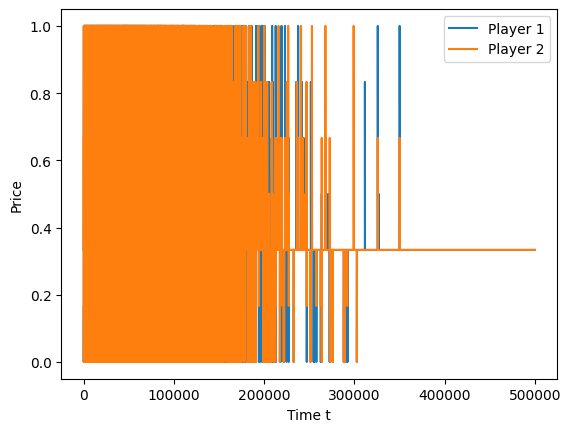

In [31]:

pro, arr, arr1, Q_t, optimality_1 = game( x, 500000, 0.3, 0.00002763)
t_arr1 = np.arange(0, 499998, 2)
t_arr2 = np.arange(1,499999,2)
print('profitability:', pro)
print('optimality player i:', optimality_1)
print('q_table player i:', Q_t)
plt.plot(t_arr1,arr,label='Player 1')
plt.plot(t_arr2,arr1, label='Player 2')
plt.xlabel("Time t")
plt.ylabel("Price")
plt.legend()
plt.show()


CHECK 249999


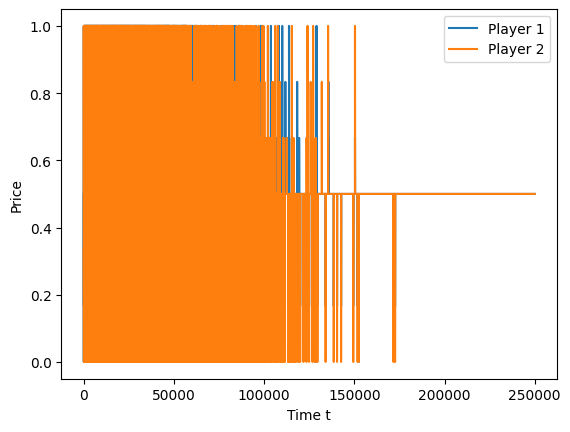

<Figure size 640x480 with 0 Axes>

In [16]:
pro, arr, arr1 = game( x, 500000, 0.3, 0.00002763)
t_arr = np.arange(249999)

plt.plot(t_arr,arr,label='Player 1')
plt.plot(t_arr,arr1, label='Player 2')
plt.xlabel("Time t")
plt.ylabel("Price")
plt.legend()
f1 = plt.figure()
plt.show()


In [ ]:
plt.plot(t_arr,pro,label='Profitability')
plt.xlabel("Time t")
plt.ylabel("Profitability")
plt.legend()
plt.show()